In [2]:
import os
import cv2
import numpy as np
import math
import pickle

import matplotlib
from matplotlib.pyplot import imshow
from general import *

%matplotlib inline

Initial code from [here](https://github.com/wroscoe/notebooks/blob/master/Port%20of%20compond%20eye.ipynb).

In [3]:
#Parameters
bottom_crop = 25
top_crop = 40
row, col = 120, 160
debug = True # False
canny_threshold1 = 50 # 100
canny_threshold2 = 200 # 130


In [8]:
import glob

dir_path = 'C:/Users/ASUS/Documents/rpis/d202/d2/data/LosTilos/tub_1_18-07-13/' # too many files
dir_path = './test_images/'

images = glob.glob(dir_path+'*.jpg')

img_all = np.array([cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in images])

#only use a couple example images
img_arr = img_all[0:5]

#find image dimensions
img = img_arr[0]
img_height = img.shape[0]
img_width = img.shape[1]

img_shape = img.shape
new_img_shape = (300,300) # for transformation

#mtx = pickle.load(open("mtx.pkl", 'rb'))
#dist = pickle.load(open("dist.pkl", 'rb'))

mtx = np.array([[268.545517, 0.000000, 156.478764],
       [0.0, 267.758343, 132.117238],
       [0.0, 0.0, 1.0]])
dist = np.array([[-0.030609, -0.071767, 0.014567, 0.008852, 0.0]])

cdata = pickle.load(open("calibrate.pkl", "rb"), encoding='latin1')

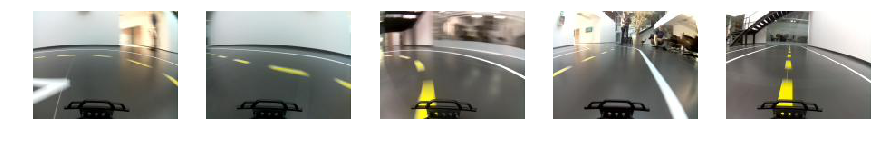

In [9]:
#original images
show_imgs(img_arr)

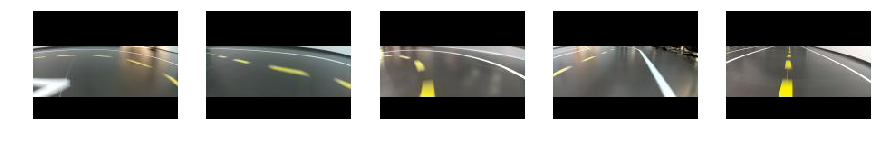

In [10]:
# Region of Interest
bottom_left = [0, img_height-bottom_crop]
top_left     = [0, top_crop]
bottom_right = [img_width, img_height-bottom_crop]
top_right    = [img_width, top_crop]
vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)

img_roi = np.array([region_of_interest(i, vertices) for i in img_arr])
show_imgs(img_roi)

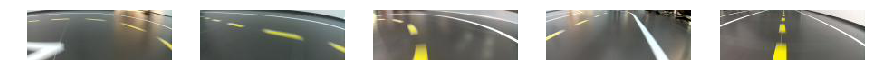

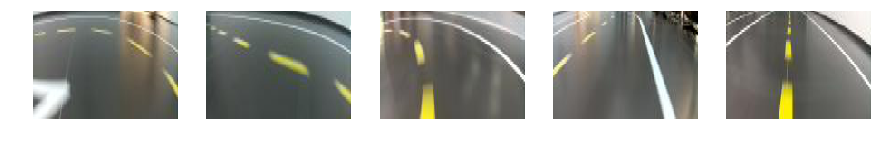

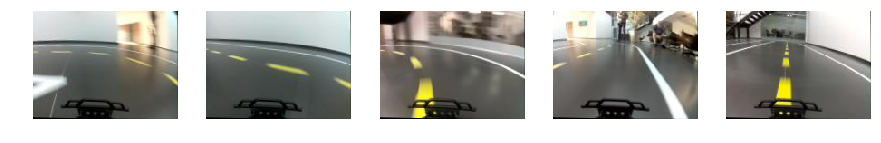

In [11]:
# Crop
img_crop = np.array([crop_image(i, 0, bottom_crop, 0, top_crop) for i in img_arr])
show_imgs(img_crop)
# Image resize
img_resize = np.array([image_resize(i, row, col) for i in img_crop])
show_imgs(img_resize)
# Undistort
img_undistort = np.array([image_undistort(i, mtx, dist) for i in img_arr])
show_imgs(img_undistort)

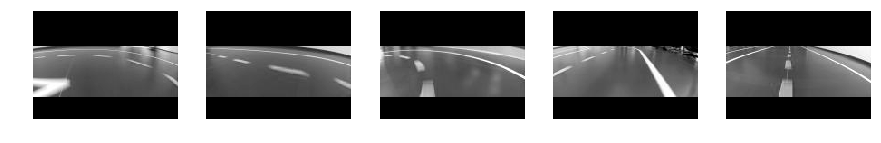

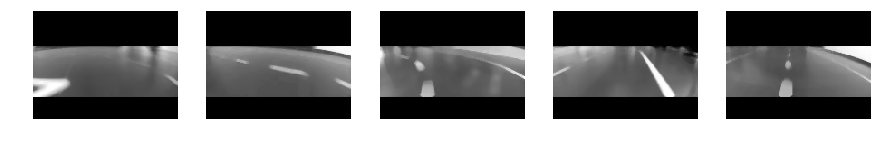

In [12]:
#remove colors and show greyscale
gray_arr = np.array([cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in img_roi])
show_imgs(gray_arr, cmap='gray')

#blur images to avoid recognizing small lines
median_blur = np.array([get_median_blur(i) for i in gray_arr])
show_imgs(median_blur, cmap='gray')

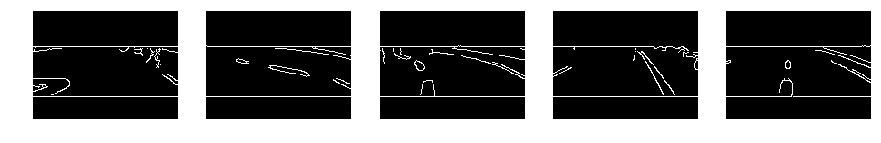

In [13]:
#use canny threshold to find edges of shapes
canny_arr = np.array([cv2.Canny(i, canny_threshold1, canny_threshold2) for i in median_blur])
show_imgs(canny_arr, cmap='gray')

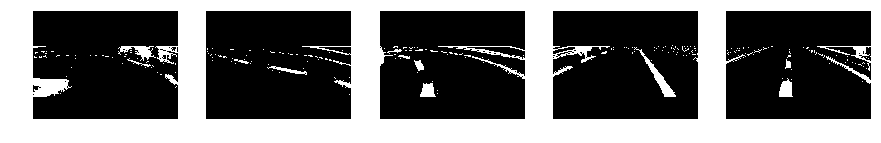

In [14]:
#thresholds
thresh_arr = np.array([thresholds(i) for i in img_roi])
show_imgs(thresh_arr, cmap='gray')

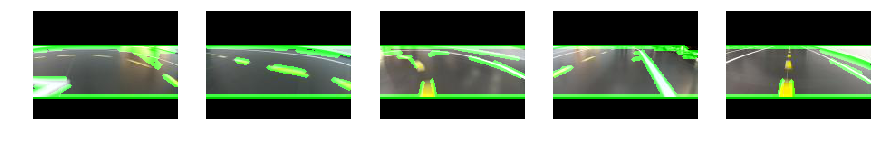

In [15]:
hough_threshold = 10
min_line_length = 10
max_gap = 10
rho = 1.
theta = np.pi/180 # around .017

line_arr = []
line_coord_arr = []
line_count = 0
for i, canny in enumerate(canny_arr): #thresh_arr  img_roi
    lines = cv2.HoughLinesP(canny, rho, theta, threshold=hough_threshold, minLineLength=min_line_length, maxLineGap=max_gap)
    i_img = img_roi[i]
    img = duplicate_image(i_img)
    if lines is not None:
        img = draw_lane_lines(img, lines, (0,255,0), 3)
    line_arr.append(img)
    
show_imgs(np.array(line_arr))